### Load and Clean Data

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

data=pd.read_csv('../Updated_data/jump_meta_data.csv')
ts_data=np.load('../Updated_data/jump_ts_data.npy')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

### Add Time Series to Dataframe

In [56]:
ts_mapping = {idx: ts_data[idx] for idx in range(len(data))}

# Add time series to corresponding index
data["time_series"] = list(ts_data)
first_ts=data.loc[0, "time_series"]


### Set NaN Values to 0

In [57]:
ts_data[np.isnan(ts_data)] = 0.0

### Create New Column 'total_force' containing sum of left and right feet per time step

In [58]:
data["total_force"] = data["time_series"].apply(lambda x: x.sum(axis=1))

### Normalize Trial Data Per Individual Trial

In [59]:
# def normalize_trial(trial_data):
#     max_value = np.max(trial_data)  # Get the max value for that specific trial
#     return trial_data / max_value if max_value != 0 else trial_data  

# # Apply normalization for each row's time series individually
# data["normalized_time_series"] = data["total_force"].apply(normalize_trial)
data["initial_value"] = data["total_force"].apply(lambda x: x[0])


data["normalized_time_series"] = data["total_force"] / data["initial_value"]

In [62]:
data.head(1)

,Unnamed: 0.1,Unnamed: 0,testID,rep,profileID,recordedUTC,Team,Category,BODY_WEIGHT_N,BODY_WEIGHT,...,RELATIVE_CONCENTRIC_RPD_100MS,TOTAL_WORK,VELOCITY_AT_PEAK_POWER,CMJ_STIFFNESS,ECCENTRIC_UNLOADING_IMPULSE,id_rep,time_series,total_force,initial_value,normalized_time_series
0,0,0,f6b0b4f3-ccaa-488c-b71b-2a9d6fd8c359,1,eb037fd9-1b41-4bee-ade5-079f3d3012f8,2023-01-06 23:31:43.937000+00:00,Acro and Tumbling,Sport,NaN,NaN,...,387.302675,352.793276,1.889667,result\nCMJ_STIFFNESS 8803.572568\nCMJ_STIF...,result\nECCENTRIC_UNLOADING_IMPULSE -42.7836...,f6b0b4f3-ccaa-488c-b71b-2a9d6fd8c359_1,"[[259.619805, 259.820513], [257.619805, 261.82...","[519.4403179999999, 519.4403179999999, 516.440...",519.440318,"[1.0, 1.0, 0.994224553050578, 0.99422455305057..."


### Normalize Data Length

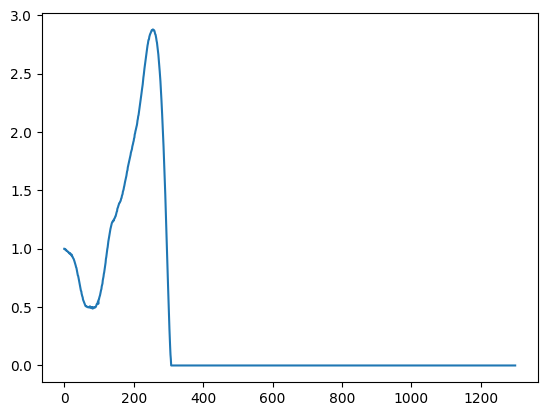

In [76]:
plt.plot(data["normalized_time_series"][0])

In [65]:
test_data = torch.tensor(data["normalized_time_series"], dtype=torch.float32).to(device)

In [66]:
import torch
import torch.nn.functional as F

def find_jump_end(sequence, threshold=1e-3):
    """Finds the last non-zero value before the flatline starts."""
    nonzero_indices = (sequence.abs() > threshold).nonzero(as_tuple=True)[0]
    return nonzero_indices[-1].item() if len(nonzero_indices) > 0 else len(sequence) - 1

def process_jump_data(data, target_length=100):
    """
    Normalizes and resamples jump data.
    
    Parameters:
        data (torch.Tensor): Original data of shape [num_samples, time_steps]
        target_length (int): Desired length for all jumps after resampling
    
    Returns:
        torch.Tensor: Processed data of shape [num_samples, target_length]
    """
    num_samples, original_length = data.shape
    processed_data = []

    for i in range(num_samples):
        # Extract sequence and find where the jump ends
        seq = data[i]
        jump_end = find_jump_end(seq)
        
        # Trim sequence up to the jump end
        trimmed_seq = seq[:jump_end + 1].unsqueeze(0)  # Shape: [1, trimmed_length]
        
        # Interpolate to target_length and remove extra dimensions
        resampled_seq = F.interpolate(trimmed_seq.unsqueeze(0), size=target_length, mode='linear', align_corners=False).squeeze(0).squeeze(0)

        processed_data.append(resampled_seq)

    return torch.stack(processed_data)


target_length = 100  # Adjust as needed
processed_data = process_jump_data(test_data, target_length)
print(processed_data.shape)  # Should now be [27695, 100]


torch.Size([30012, 100])


### Save Downsampled into DataFrame

In [67]:
import pandas as pd
processed_list = processed_data.cpu().numpy().tolist()  
data["downsampled_time_series"] = processed_list  

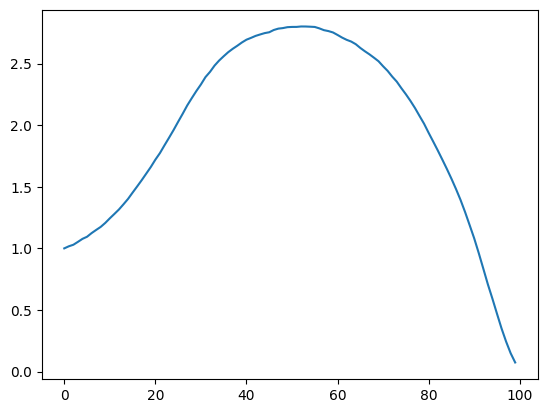

In [75]:
plt.plot(data["downsampled_time_series"][1])

In [80]:
len(data["downsampled_time_series"][0])
# data.head(1)


100

### Save Cleaned Data in Pickle

In [81]:
data.to_pickle("cleaned_data.pkl")
